加载库文件

In [2]:
import warnings
from collections import Counter
import torchvision
from pytorch_lightning import seed_everything
from skimage.io import imread
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score


%matplotlib inline
plt.rcParams['figure.figsize'] = (3.5, 2.5)
%config InlineBackend.figure_format = 'jpg'
warnings.filterwarnings("ignore")
seed_everything(seed=42)

Seed set to 42


42

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 数据集地址 
data_path = 'E:/lung_classify/dataset'
train_dir = data_path + '/train'
val_dir = data_path + '/val'
test_dir = data_path + '/test'
# 函数定义
def toOneHot(ylabels, n_class):
    onehot = torch.zeros(ylabels.shape[0], n_class)
    index = torch.LongTensor(ylabels).view(-1, 1)
    onehot.scatter_(dim=1, index=index, value=1)
    return onehot
def expToTorch(x):
    return torch.from_numpy(np.array(x)).double()
# 数据增强
def DataTransforms(phase=None):
    if phase == 'train':
        data = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=(224, 224)),
            torchvision.transforms.RandomRotation(degrees=(-20, +20)),
            torchvision.transforms.ColorJitter((1.2, 1.5)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
        ])

    elif phase == 'test' or phase == 'val':
        data = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=(224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
        ])

    return data

# 数据增强可视化
def show_image(image,title = None,get_denormalize = False):

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    image = image*std + mean
    image = np.clip(image,0,1)

    if get_denormalize == False:
        plt.figure(figsize=[15, 15])
        plt.imshow(image)

        if title != None:
            plt.title(title)

    else : 
        return image

# 计算准确率
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

# 分类可视化
def view_classify(img,ps,label):

    class_name = ['正常', '肺炎']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    img = show_image(img,get_denormalize = True)



    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('真实值 : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('预测类别')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

数据信息预处理

In [4]:
trainset = torchvision.datasets.ImageFolder(train_dir,transform = DataTransforms('train'))
testset = torchvision.datasets.ImageFolder(test_dir,transform = DataTransforms('test'))
validset = torchvision.datasets.ImageFolder(val_dir,transform = DataTransforms('val'))

class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


数据检查

正常 vs 肺炎 比列: 0.3460645161290323


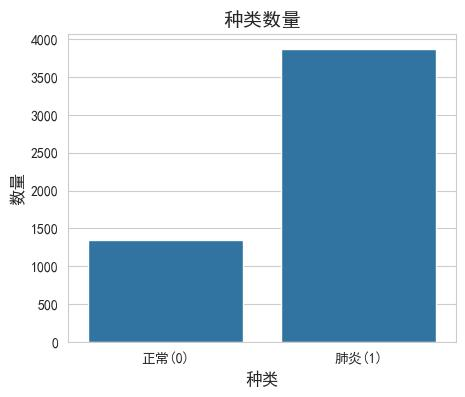

In [5]:
import seaborn as sns
plt.rcParams['font.family']='SimHei'
cases_count = list(Counter(trainset.targets).values())
print("正常 vs 肺炎 比列: {}".format(cases_count[0]/ cases_count[1]))
# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=list(Counter(trainset.targets).keys()), y= cases_count)
plt.title('种类数量', fontsize=14)
plt.xlabel('种类', fontsize=12)
plt.ylabel('数量', fontsize=12)
plt.xticks(list(Counter(trainset.targets).keys()), ['正常(0)', '肺炎(1)'])
plt.show();

数据可视化

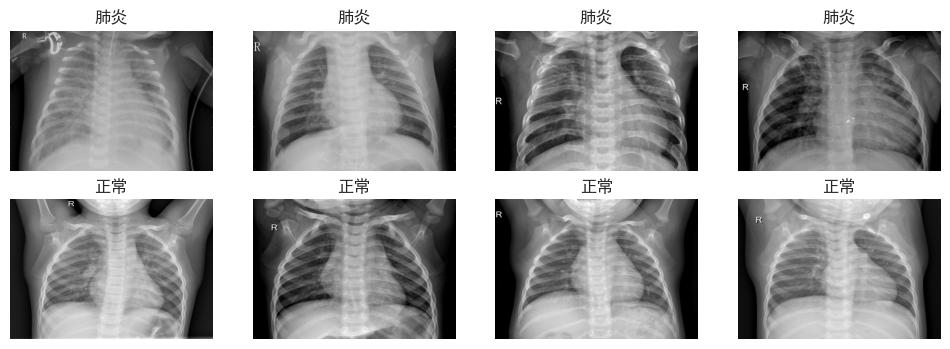

In [6]:

pneumonia_samples = [trainset.imgs[i][0] for i in range(len(trainset.imgs)) if trainset.targets[i] == 1][:4]
normal_samples = [trainset.imgs[i][0] for i in range(len(trainset.imgs)) if trainset.targets[i] == 0][:4]

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,4, figsize=(12,4))
for i in range(8):
    img = imread(samples[i])
    ax[i//4, i%4].imshow(img, cmap='gray')
    if i<4:
        ax[i//4, i%4].set_title("肺炎")
    else:
        ax[i//4, i%4].set_title("正常")
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_aspect('auto')
plt.show();

数据读取

In [7]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)
validloader = DataLoader(validset,batch_size = 8,shuffle = True)
testloader = DataLoader(testset,batch_size = 8,shuffle = True)

展示数据增强的结果

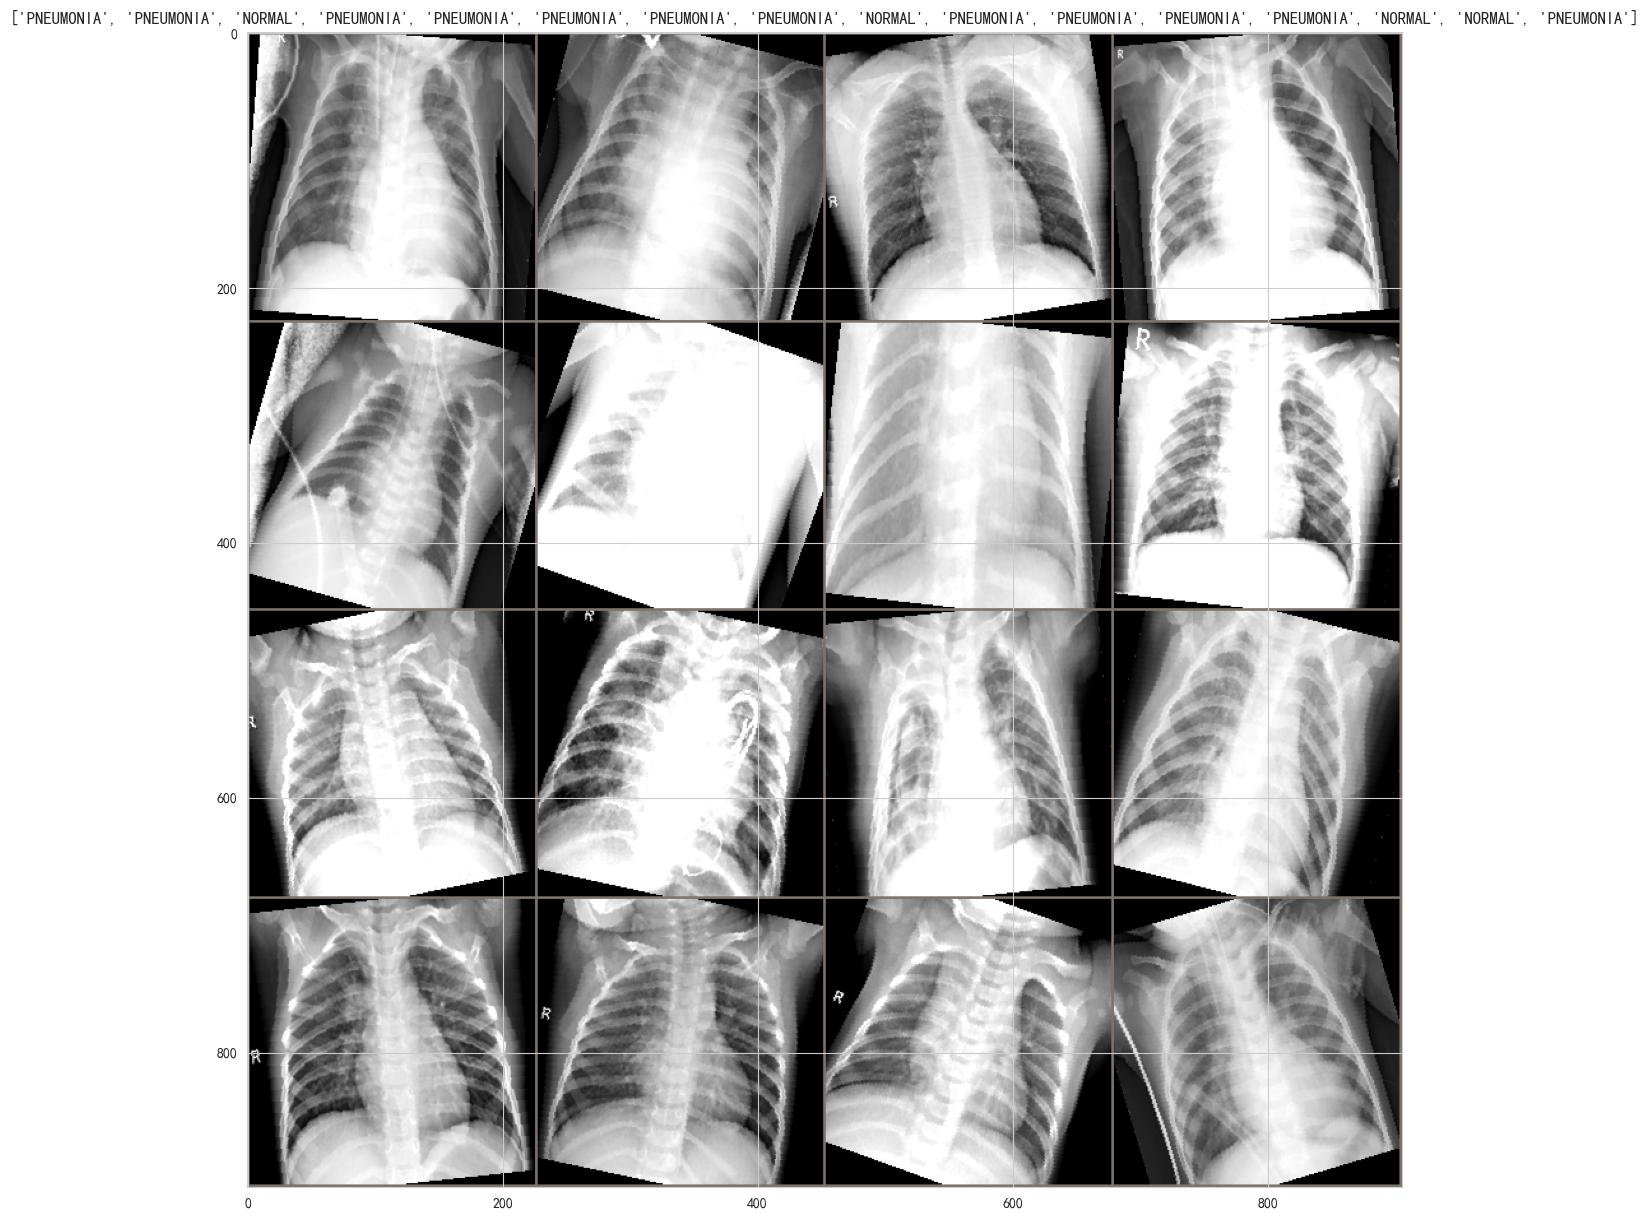

In [8]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

out = make_grid(images,nrow=4)

show_image(out, title=[class_names[x] for x in labels])

In [9]:
# 使用迁移学习方法，使用预训练模型
model = models.vgg16(pretrained=True)

# 冻结参数
for param in model.parameters():
    param.requires_grad = False

# 修改全连接层
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                         ('relu', nn.ReLU()),
                                         ('dropout',nn.Dropout(0.3)),
                                         ('fc2', nn.Linear(4096, 4096)),
                                         ('relu', nn.ReLU()),
                                         ('drop', nn.Dropout(0.3)),
                                         ('fc3', nn.Linear(4096, 2)), 
                                         ('output', nn.LogSoftmax(dim = 1))]))
model.classifier = classifier
model.to(device)

# 定义损失函数和优化器
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 15
valid_loss_min = np.Inf
for i in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 


    model.train()

    for images,labels in tqdm(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ps = model(images)
        loss = criterion(ps,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc += accuracy(ps,labels)
        train_loss += loss.item()

    avg_train_acc = train_acc / len(trainloader)
    avg_train_loss = train_loss / len(trainloader)

    model.eval()
    with torch.no_grad():

        for images,labels in tqdm(validloader):

            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            loss = criterion(ps,labels)

            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()


        avg_valid_acc = valid_acc / len(validloader)
        avg_valid_loss = valid_loss / len(validloader)

        schedular.step(avg_valid_loss)

        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'Pneumonia_model.pt')

            valid_loss_min = avg_valid_loss


    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))

100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Validation loss decreased (inf --> 0.695762).   Saving model ...
Epoch : 1 Train Loss : 0.994331 Train Acc : 0.918136
Epoch : 1 Valid Loss : 0.695762 Valid Acc : 0.625000


100%|██████████| 2/2 [00:00<00:00,  7.92it/s]


Validation loss decreased (0.695762 --> 0.042225).   Saving model ...
Epoch : 2 Train Loss : 0.121379 Train Acc : 0.955905
Epoch : 2 Valid Loss : 0.042225 Valid Acc : 1.000000


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch : 3 Train Loss : 0.106897 Train Acc : 0.963765
Epoch : 3 Valid Loss : 0.156455 Valid Acc : 0.937500


100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


Epoch : 4 Train Loss : 0.102990 Train Acc : 0.962807
Epoch : 4 Valid Loss : 0.134422 Valid Acc : 0.937500


100%|██████████| 2/2 [00:00<00:00,  7.83it/s]


Validation loss decreased (0.042225 --> 0.034362).   Saving model ...
Epoch : 5 Train Loss : 0.135024 Train Acc : 0.959164
Epoch : 5 Valid Loss : 0.034362 Valid Acc : 1.000000


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Validation loss decreased (0.034362 --> 0.016503).   Saving model ...
Epoch : 6 Train Loss : 0.135686 Train Acc : 0.957439
Epoch : 6 Valid Loss : 0.016503 Valid Acc : 1.000000


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch : 7 Train Loss : 0.126526 Train Acc : 0.963382
Epoch : 7 Valid Loss : 0.306641 Valid Acc : 0.812500


100%|██████████| 2/2 [00:00<00:00,  7.54it/s]


Epoch : 8 Train Loss : 0.155658 Train Acc : 0.952454
Epoch : 8 Valid Loss : 0.267016 Valid Acc : 0.937500


100%|██████████| 2/2 [00:00<00:00,  7.78it/s]


Validation loss decreased (0.016503 --> 0.003534).   Saving model ...
Epoch : 9 Train Loss : 0.194816 Train Acc : 0.957247
Epoch : 9 Valid Loss : 0.003534 Valid Acc : 1.000000


100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


Epoch : 10 Train Loss : 0.164094 Train Acc : 0.949770
Epoch : 10 Valid Loss : 0.108965 Valid Acc : 1.000000


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Epoch : 11 Train Loss : 0.174560 Train Acc : 0.940951
Epoch : 11 Valid Loss : 0.414811 Valid Acc : 0.875000


100%|██████████| 2/2 [00:00<00:00,  7.52it/s]


Epoch : 12 Train Loss : 0.131305 Train Acc : 0.953796
Epoch : 12 Valid Loss : 0.050335 Valid Acc : 1.000000


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Epoch : 13 Train Loss : 0.133879 Train Acc : 0.960506
Epoch : 13 Valid Loss : 0.022601 Valid Acc : 1.000000


100%|██████████| 2/2 [00:00<00:00,  7.42it/s]


Epoch : 14 Train Loss : 0.137055 Train Acc : 0.955330
Epoch : 14 Valid Loss : 0.197840 Valid Acc : 0.937500


100%|██████████| 2/2 [00:00<00:00,  7.73it/s]

Epoch : 15 Train Loss : 0.155734 Train Acc : 0.951304
Epoch : 15 Valid Loss : 0.798112 Valid Acc : 0.937500


评估模型

In [13]:
model.eval()

test_loss = 0
test_acc = 0
all_preds = []
all_labels = []
for images,labels in testloader:

    images = images.to(device)
    labels = labels.to(device)

    pred = model(images)
    loss = criterion(pred,labels)
    
    _, preds = torch.max(pred, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    
    test_loss += loss.item()
    test_acc += accuracy(pred,labels)

avg_test_loss = test_loss/len(testloader)
avg_test_acc = test_acc/len(testloader)

# 计算混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_preds)

# 计算FP和FN
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)

# 计算F1分数
F1 = f1_score(all_labels, all_preds, average='weighted')

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(avg_test_loss,avg_test_acc))
print("FP:", FP[1])
print("FN:", FN[1])
print("F1 Score:", F1)
print("Confusion Matrix:")
print(conf_matrix)

Test Loss : 2.590416 Test Acc : 0.875000
FP: 40
FN: 38
F1 Score: 0.8748916062039671
Confusion Matrix:
[[194  40]
 [ 38 352]]


模型可视化

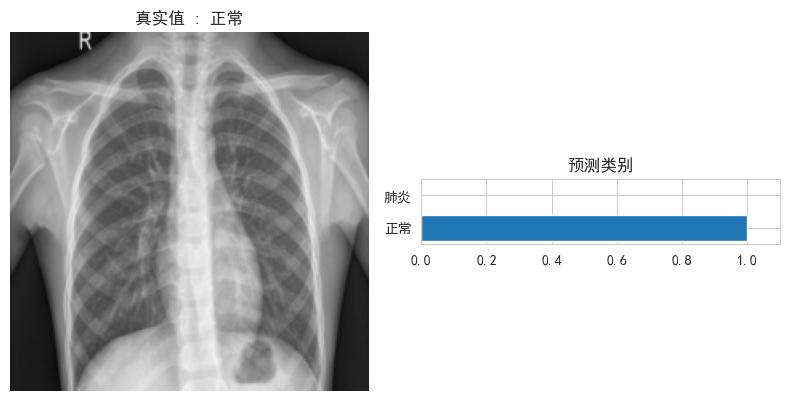

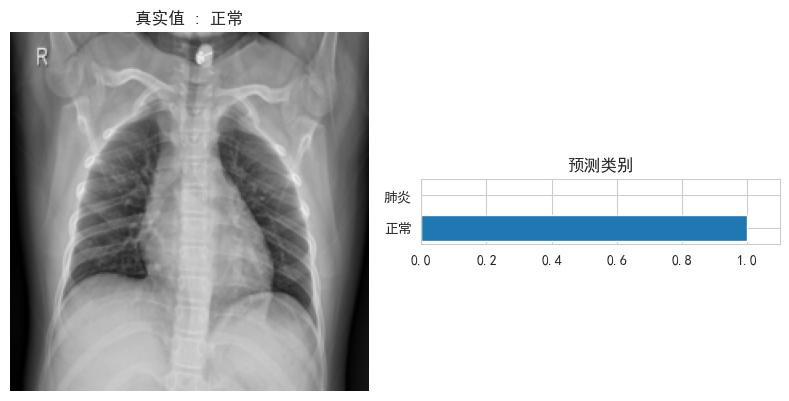

In [11]:
image,label = testset[0]

ps = torch.exp(model(image.to(device).unsqueeze(0)))
view_classify(image,ps,label)
image,label = testset[36]

ps = torch.exp(model(image.to(device).unsqueeze(0)))
view_classify(image,ps,label)